In [1]:
import pandas as pd
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
import random as rn
from tqdm import tqdm
import seaborn as sns
from collections import Counter
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from hs_gimme.logging_service.problems_only_logging_service import ProblemsOnlyLoggingService
from collections import Counter
from hs_recommendations_api_client import get_recommendations_api_client

In [2]:
ENV = 'production'
ACCOUNT = 'granada'

In [3]:
mongo = get_mongo_client_db(ENV, ACCOUNT)

In [4]:
req_q = {
    'job_create_date': {'$gt': datetime(2022, 1, 1)}, 
    'external_status': 'Closed',
    'is_evergreen': False,
   # 'is_gradable': True
}

In [ ]:
sorted(req.keys())

In [5]:
mongo.req.count_documents(req_q)

13762

In [6]:
req_ids = mongo.req.distinct('_id', req_q)

In [7]:
sample_ids = req_ids#rn.sample(req_ids, 1000)

In [8]:

def get_data_for_req(req, mongo):
    result = []
    
    apps = list(mongo.application.find({'req_id': req['_id']},  ['ats_application.status_info.status_history', 'date_applied']))
    
    req_data = []
    any_interview = False
    any_offer = False
    for app in apps:
        days = (app['date_applied'] - req['job_create_date']).days
        interview = any('Rd ' in s.get('step_name', '') for s in app['ats_application']['status_info']['status_history'])
        offer = any('Offer' in s.get('step_name', '') for s in app['ats_application']['status_info']['status_history'])
        req_data.append({'days': days, 'interview': interview, 'offer': offer})
        
        any_interview = any_interview or interview
        any_offer = any_offer or offer

    df = pd.DataFrame(req_data)
    
    if any_interview and any_offer and df['days'].max() > 1 and len(apps) > 2:
        result = []
        for days in range(df['days'].max() + 1):
            result.append({
                'req_id': req['_id'],
                'days': days,
                'req': req,
                'num_of_apps': len(df[df['days'] <= days]),
                'num_of_interview': len(df[(df['days'] <= days) & df['interview']]),
                'num_of_offer': len(df[(df['days'] <= days) & df['offer']]),
            })
    return result

In [9]:
data = []
for req in tqdm(mongo.req.find({'_id': {'$in': sample_ids}}, ['job_create_date']), total=len(sample_ids)):
    data += get_data_for_req(req, mongo)
df = pd.DataFrame(data)
len(df), df['req_id'].nunique()

 28%|███████████████████████████████████████████████▏                                                                                                                      | 3909/13762 [18:07<46:05,  3.56it/s]

2023-07-24T16:20:55.463805Z [warning  ] SlowLog                        command_name=getMore connection_id=mongodb-3c.prod.omcomcom.com:27029 duration_ms__numeric=10437.788 duration_threshold__numeric=10000 environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/slow_logs_utils.py function_name=write_slow_log hostname=Dima-Shulga-MacBook-Pro line_number=11 module=hs_gimme.db_facade.slow_logs_utils pid=84331 request_id=1452948133 source=PyMongo stack_snippet=
  File "/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_84331/2268121598.py", line 4, in get_data_for_req
    apps = list(mongo.application.find({'req_id': req['_id']},  ['ats_application.status_info.status_history', 'date_applied']))



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13762/13762 [56:24<00:00,  4.07it/s]


(163332, 1223)

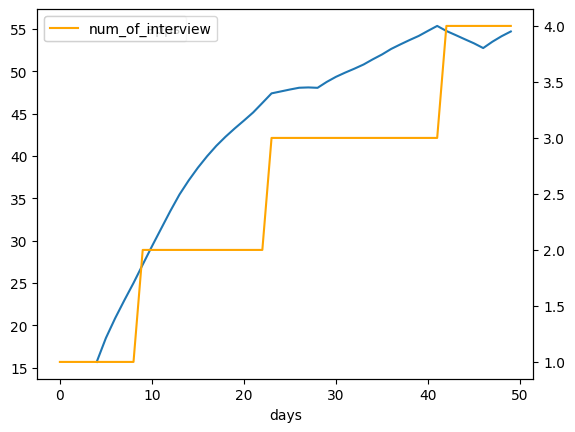

In [40]:
mask = lambda x: x['days'] < 50
ax = df[mask].groupby(['days'])[['num_of_apps']].mean().rolling(5).mean().plot()
ax2 = ax.twinx()
ax = df[mask].groupby(['days'])[['num_of_interview']].mean().round().plot(ax=ax2, color=['orange'])

# COVERAGE

In [12]:
open_q = {
    'job_create_date': {'$gt': datetime(2023, 7, 1)}, 
    'external_status': 'Open'
}

In [48]:
mongo.req.count_documents(open_q)

613

In [47]:
open_req_ids = mongo.req.distinct('_id', open_q)
len(open_req_ids)

613

In [42]:
open_req_ids = open_req_ids#rn.sample(open_req_ids, 100)

In [35]:
open_data = []

for req in tqdm(mongo.req.find({'_id': {'$in': open_req_ids}}, ['job_create_date']), total=len(open_req_ids)):
    open_data += get_data_for_req(req, mongo)
open_df = pd.DataFrame(open_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


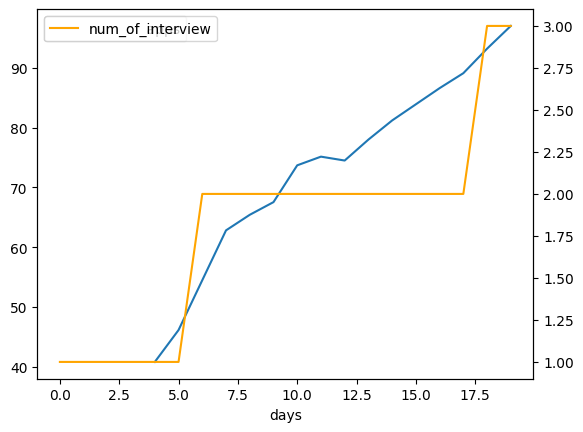

In [36]:
mask = lambda x: x['days'] < 300
ax = open_df[mask].groupby(['days'])[['num_of_apps']].mean().rolling(5).mean().plot()
ax2 = ax.twinx()
ax = open_df[mask].groupby(['days'])[['num_of_interview']].mean().round().plot(ax=ax2, color=['orange'])

In [18]:
api = get_recommendations_api_client(environment='production', logger=ProblemsOnlyLoggingService())

In [49]:
len(open_req_ids)

613

In [51]:
recommandations = {}
request_kwargs = {"fetch_mode": {"value": "talent_fetch"},
        "allow_already_applied_req": {"value": False},
        "allow_candidates_with_offer": {"value": False}
}


for req_id in tqdm(open_req_ids):
    r = api.fast_fetch('granada', req_id, **request_kwargs)
    recommandations[req_id] = r['total_count']
        
len(recommandations)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [24:29<00:00,  2.40s/it]


613

In [52]:
reqs_df = pd.DataFrame({'req_id': k, 'num_of_recs': v} for k, v in recommandations.items())

In [53]:
reqs_df.head()

,req_id,num_of_recs
0,GSG105376,0
1,GSG106973,2
2,GSG109313,259
3,GSG110630,9
4,GSG110878,1


<Axes: >

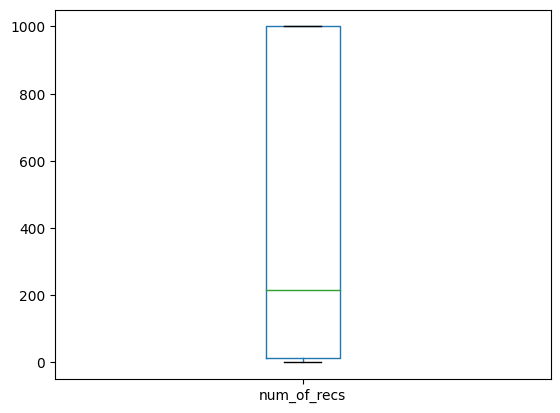

In [54]:
reqs_df.boxplot(column='num_of_recs', grid = False)

In [55]:
def get_group(n):
    if n == 0:
        return '0'
    
    if n < 10:
        return 'less than 10'
    
    if n < 50:
        return 'less than 50'
    
    return 'More than 50'

In [56]:
reqs_df['group'] = reqs_df['num_of_recs'].apply(get_group)

In [57]:
reqs_df['group'].value_counts(normalize=True)

More than 50    0.654160
0               0.163132
less than 50    0.122349
less than 10    0.060359
Name: group, dtype: float64